In [53]:
# Import relevant packages
import math
import pandas as pd
import numpy as np
import numpy.ma as ma
import datetime
import geopandas as gpd
import shapely
import sys

import plotly.graph_objects as go
import contextily as cx
from tqdm import tqdm
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Point, Polygon, LineString
import os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px

import json

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column

plt.plot()
plt.close()

months=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
days = ['mon','tue','wed','thu','fri','sat','sun']


In [2]:
# Import data on 1) gemeenten
geemapNL=gpd.read_file(r'C:/Users/MC/OneDrive - Stokhos BV/onDesktopBTO/Stokhos/geodata/gadm41_NLD_2.json')
geemapNLL=geemapNL.loc[geemapNL.ENGTYPE_2=='Municipality'] #excludes waterbodies

# 2) GGd regions
ggdmap=gpd.read_file(r'C:/Users/MC/OneDrive - Stokhos BV/onDesktopBTO/Stokhos/geodata/GGD_Regiogrenzen.json')

# 3) stations
stationinfo=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/onDesktopBTO/Stokhos/regiosdata/fgm/FLGVregio_info.xlsx','Station FLGV')
geostat=np.array(stationinfo[1:])[:,2:]
statdf=pd.DataFrame({'Station':geostat[:,0].tolist(),'Latitude':geostat[:,1].tolist(),'Longitude':geostat[:,2].tolist()})
# turn into gdf
statgdf=gpd.GeoDataFrame(statdf, geometry=gpd.points_from_xy(statdf.Longitude, statdf.Latitude))
statgdf.crs='epsg:4326'
#statgdf=statgdf.to_crs(epsg=3857) converts geometry to dutch grid

fldgemten=[]
for i in range(len(geemapNL)):
    if geemapNL['NAME_1'][i]=='Flevoland':
        fldgemten.append(geemapNL['NAME_2'][i])
gvs_gemten=['Blaricum','GooiseMeren','Hilversum','Huizen','Laren','Weesp','Wijdemeren']
flgv_gemten=fldgemten+gvs_gemten 

# Map of the FGV geemente
geefgv=geemapNL.loc[[geemapNL['NAME_2'][i] in flgv_gemten for i in range(len(geemapNL))]]
geefgv['geometry']=geefgv.translate(xoff=-0.005)

rest_map=ggdmap.loc[(ggdmap['statnaam']!='GGD Flevoland') & (ggdmap['statnaam']!='GGD Gooi en Vechtstreek')]

C:\Users\MC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Import data from xlsx files

In [3]:
data_fld=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/onDesktopBTO/Stokhos/regiosdata/fgm/FLD_08_21-09_22.xlsx')
data_gvs=pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/onDesktopBTO/Stokhos/regiosdata/fgm/GVS_08_21-09_22.xlsx')
flgv_post=np.vstack((np.array(data_fld)[:,2:],np.array(data_gvs)[:,2:]))
flgv_post=np.delete(flgv_post,[2,3,4,5,6,7,8,12,13,14,15,16,17,18,19,20,21,22],axis=1)

### Clean datasets and create geo-DataFrame

In [4]:
invalid_timestamps=[]
for i in range(len(flgv_post)):
    if (flgv_post[i,1]-flgv_post[i,0]).total_seconds()>3600: #time delta between call and ride assignment toolong 'f >1h
        invalid_timestamps.append(i)
flgv_post = pd.DataFrame(np.delete(flgv_post,invalid_timestamps,axis=0)) #only records correct calls regardeless of ridetype
flgv_post.rename(columns={2:'Station',3:'xcoord',4:'ycoord',5:'urg',0:'CallTime'},inplace=True)

gdf = gpd.GeoDataFrame(flgv_post, geometry=gpd.points_from_xy(flgv_post.xcoord, flgv_post.ycoord))
gdf.crs='epsg:28992'
gdf=gdf.to_crs(epsg=4326)
gdf_within_fgv = gdf.loc[gdf.within(geefgv.geometry.unary_union)].reset_index().drop('index',axis=1)
gdf_within_fgv = gdf_within_fgv.assign(lon = gdf_within_fgv.geometry.x.to_list())
gdf_within_fgv= gdf_within_fgv.assign(lat = gdf_within_fgv.geometry.y.to_list())

### Import hexagons centres to reconstruct Hexagons

In [5]:
hex_centres = [None]*4 # Initialize a list with 4 None elements
for i, region in enumerate(['Flevoland Gooi Vecht (FGM)','Zuid Holland Zuid (ZHZ)','Twente','IJsselland']):
    hex_centres[i] = pd.read_excel(r'C:/Users/MC/OneDrive - Stokhos BV/onDesktopBTO/Stokhos/geodata/Hex_coords.xlsx',region).drop('Unnamed: 0',axis=1).drop(0).reset_index().drop('index',axis=1)
    hex_centres[i] = hex_centres[i].rename(columns={hex_centres[i].columns[1]: "lon", hex_centres[i].columns[0]: "lat"})
    hex_centres[i] = hex_centres[i].reindex(columns=hex_centres[i].columns[::-1])
    hex_centres[i].sort_values(by=['lon', 'lat']).reset_index().drop('index',axis=1)
    hex_centres[i]['hexID'] = hex_centres[i].reset_index().index

In [12]:
def make_hexagons(center_coords):

    # Define the size of the hexagons    
    avg_distance=np.mean([center_coords.lon.loc[i+1]-center_coords.lon.loc[i+0] for i in range(10) if (center_coords.lon.loc[i+1]-center_coords.lon.loc[i])>0])
    rad_km = avg_distance / np.sqrt(3) * 111.320 * np.cos(math.radians(center_coords.loc[5].lat))

    hexagons = []
    hex_vertices = []
    
    for j in range(len(center_coords)):
        
        center_km = [center_coords.loc[j].lon * 111.320 * np.cos(math.radians(center_coords.loc[j].lat)) , center_coords.loc[j].lat * 110.574]
        vertices = []
        
        for i in range(6):

            angle = np.pi/6 + np.pi/3 * i
            # find new vertices coords and immediately convert back to deg 
            ver_lon = (center_km[0] + rad_km * np.cos(angle)) / (111.320 * np.cos(math.radians(center_coords.loc[j].lat)))  
            ver_lat = (center_km[1] + rad_km * np.sin(angle)) / 110.574
            vertices.append((ver_lon,ver_lat))

        hexagons.append(Polygon(vertices))
    
    return hexagons

hex_grid_A1=gpd.GeoDataFrame({'geometry':make_hexagons(hex_centres[0])})
hex_grid_A1.crs='epsg:4326'

hex_grid_A2=gpd.GeoDataFrame({'geometry':make_hexagons(hex_centres[0])})
hex_grid_A2.crs='epsg:4326'

hex_grids=[hex_grid_A1,hex_grid_A2]

## Fill hexagon grids with number of incidents per weekda per month

In [13]:
for i,urg in enumerate(['A1','A2']):
    hex_grid=hex_grids[i]
    for month in tqdm(range(1,13)):
        for weekday in range(7):
            ridesMonthDay = gdf_within_fgv[(gdf_within_fgv['urg']==f'{urg}') & (gdf_within_fgv['CallTime'].dt.weekday==weekday)  & (gdf_within_fgv['CallTime'].dt.month==month)]
            #normalisation is number of mondays,sundays ets in any given month.
            normalisation = len(np.unique(gdf_within_fgv[(gdf_within_fgv['CallTime'].dt.weekday==weekday)  & (gdf_within_fgv['CallTime'].dt.month==month)].CallTime.dt.date))            
            if normalisation==0: 
                normalisation=1
            #in following line rides are assigned to hexagons
            column_to_insert = [ridesMonthDay.within(hex_grid.loc[i].geometry).sum()/normalisation for i in range(len(hex_grid))]
            hex_grid.insert(np.shape(hex_grid)[1],f"month:{month}:-day:{weekday+1}",column_to_insert)

100%|██████████| 12/12 [00:53<00:00,  4.46s/it]


## HexBin plot done by Matplotlib

backgroud added. now binning


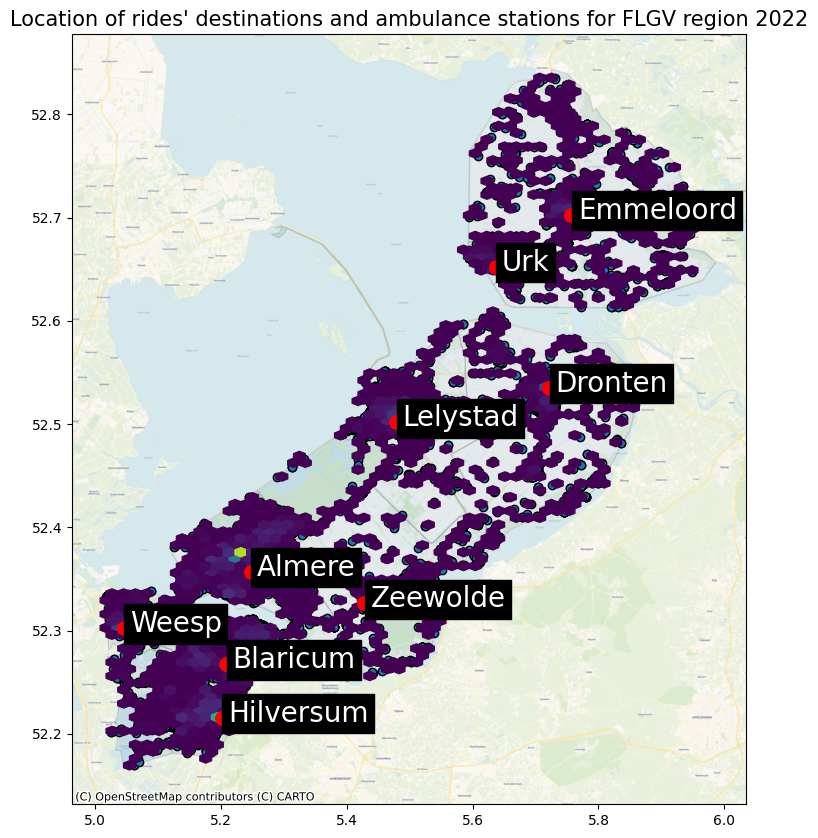

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
geefgv.plot(ax=ax,alpha=0.1, edgecolor='k')
gdf_within_fgv.plot(ax=ax,edgecolor='k')
plt.title('Location of rides\' destinations and ambulance stations for FLGV region 2022', fontsize=15)
cx.add_basemap(ax,crs=geefgv.crs,zoom=12,source=cx.providers.CartoDB.Voyager)
print("backgroud added. now binning")
hexs = plt.hexbin(gdf_within_fgv.geometry.x.to_list()
                        ,gdf_within_fgv.geometry.y.to_list()
                        , gridsize=(50,50),mincnt=1)
for i in range(len(statgdf)):
    statgdf.plot(ax=ax,label=geostat[i,0],markersize=80,c='r')
    ax.text(float(statgdf.loc[i].geometry.x)+0.01, float(statgdf.loc[i].geometry.y)-0.004,geostat[i,0],
            fontsize=20, backgroundcolor='k',c='w')

<AxesSubplot: >

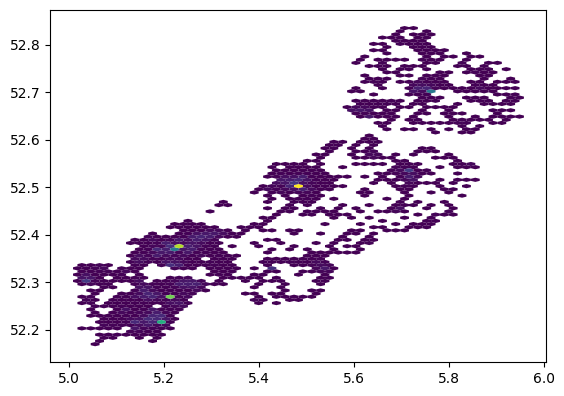

In [9]:
def polygons_from_hexbins(collection):
    hex_polys = collection.get_paths()[0].vertices
    hex_array = []
    for xs,ys in collection.get_offsets():
        hex_x = np.add(hex_polys[:,0],  xs)
        hex_y = np.add(hex_polys[:,1],  ys)
        hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))

    counts = collection.get_array()
    return gpd.GeoDataFrame({'count': counts, 'geometry':hex_array})

geobins = polygons_from_hexbins(hexs)
geobins.plot(column="count")

## Plot averaged demand Matrix

0
1


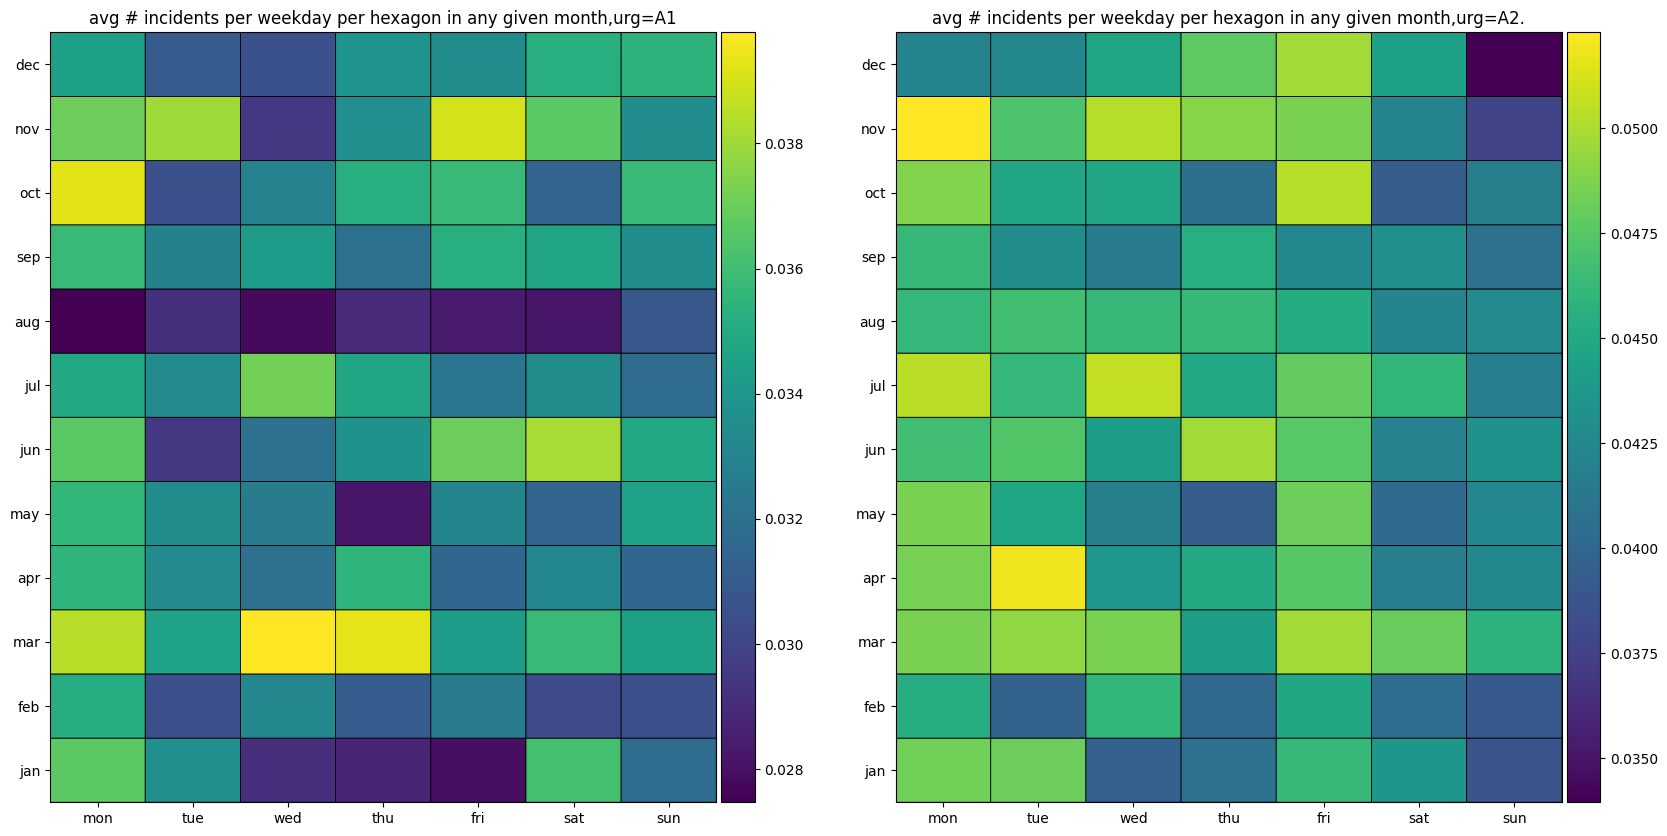

In [10]:
def pcolorplotter(hexdata):
    data2D=[]
    urgs=["A1","A2"]
    x=[i+0.5 for i in range(8)]
    y=[i+0.5 for i in range(13)]

    for i,data in enumerate(hexdata):
        print(i)
        maxIncPerWeekday = data.iloc[:,1:].max()
        meanIncPerWeekday= data.iloc[:,1:].mean()
        meanIncPerWeekday=np.array(meanIncPerWeekday)
        data_2d=np.reshape(meanIncPerWeekday,(12,7))
        data2D.append(np.reshape(meanIncPerWeekday, (12,7)))

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    im1 = ax1.pcolor(data2D[0],cmap='viridis',vmin=np.min(data2D[0]), vmax=np.max(data2D[0]),edgecolors='k', linewidths=0.6)
    ax1.set_xticks(x[:-1],days)
    ax1.set_yticks(y[:-1],months)
    ax1.set_title(f'avg # incidents per weekday per hexagon in any given month,urg={urgs[0]}')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(122)
    im2 = ax2.pcolor(data2D[1],cmap='viridis',vmin=np.min(data2D[1]), vmax=np.max(data2D[1]),edgecolors='k', linewidths=0.6)
    ax2.set_xticks(x[:-1],days)
    ax2.set_yticks(y[:-1],months)
    ax2.set_title(f'avg # incidents per weekday per hexagon in any given month,urg={urgs[1]}.')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    #fig,axs=plt.subplots(1,len(hexdata),figsize=(len(hexdata)*10,10))
    #c=plt.pcolor(data_2d,cmap='viridis',vmin=np.min(meanIncPerWeekday), vmax=np.max(meanIncPerWeekday),edgecolors='k', linewidths=0.6)
    #for j in range(2):    
    #    c=axs[j].pcolor(data2D[j],cmap='viridis',vmin=np.min(meanIncPerWeekday), vmax=np.max(meanIncPerWeekday),edgecolors='k', linewidths=0.6)
    #    axs[j].set_xticks(x[:-1],days)
    #    axs[j].set_yticks(y[:-1],months)
    #    axs[j].set_title(f'Spatially-averaged demand,urg={urgs[i]}')
    #    axs[j].colorbar(c)

pcolorplotter(hex_grids)


## Make interactive plot

In [142]:
# Define a sequential multi-hue color palette.
palette = brewer['Blues'][8]
# Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
# Create a function the returns json_data for the month selected by the user
def json_data(selectedMonth,selectedDay):
    mn = selectedMonth
    dd = selectedDay

    gdf = hex_grid_A1.iloc[:,0:1]
    # Pull selected month from geodatafram
    gdf_mn_day = hex_grid_A1.filter(like=f"month:{selectedMonth}:-day:{selectedDay}")
    
    # Merge the GeoDataframe object (sf) with the neighborhood summary data (neighborhood)
    merged =  gpd.GeoDataFrame(pd.concat([gdf,gdf_mn_day],axis=1))
    # Bokeh uses geojson formatting, representing geographical features, with json
    mergedToLoad=merged.to_json()
    # Convert to json
    merged_json = json.loads(mergedToLoad)
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data

# Input geojson source that contains features for plotting for:
geosource = GeoJSONDataSource(geojson = json_data(1,1))

# Define the callback function: update_plot
def update_plot(attr, old, new):

    month = mon_slider.value
    day = day_slider.value
    new_data = json_data(month,day)
        
    # Update the plot based on the changed inputs
    p = make_plot()
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, widgetbox(mon_slider), widgetbox(day_slider))
    curdoc().clear()
    curdoc().add_root(layout)
    
    # Update the data
    geosource.geojson = new_data

# Create a plotting function
def make_plot(month,day):    

  date=f"month:{month}:-day:{day}"
  # Set the format of the colorbar
  min_range = np.array(hex_grid_A1.filter(like=f"month:{month}:-day:{day}").min())[0]
  max_range = np.array(hex_grid_A1.filter(like=f"month:{month}:-day:{day}").max())[0]
  
  # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
  color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)

  # Create color bar.
  color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18,border_line_color=None, location = (0, 0))

  # Create figure object.
  p = figure(title = f'Average number of Incidents on weekday{day} of Month{month}', 
            plot_height = 650, plot_width = 850,
            toolbar_location = None)
  p.xgrid.grid_line_color = None
  p.ygrid.grid_line_color = None
  p.axis.visible = False
  # Add patch renderer to figure. 
  p.patches('xs','ys', source = geosource, fill_color = {'field' : date, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
  
  # Specify color bar layout.
  p.add_layout(color_bar, 'right')

  # Add the hover tool to the graph
  return p

# Call the plotting function
p = make_plot(1,1)

# Make a slider object: slider 
mon_slider = Slider(title = 'Month',start = 1, end = 12, step = 1, value = 1)
mon_slider.on_change('value', update_plot)
# Make a slider object: slider 
day_slider = Slider(title = 'Weekday',start = 1, end = 7, step = 1, value = 1)
day_slider.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
layout = column(p, widgetbox(mon_slider), widgetbox(day_slider))
curdoc().add_root(layout)


Loading BokehJS ...

In [134]:
neighborhood_data = pd.read_csv('https://raw.githubusercontent.com/JimKing100/SF_Real_Estate_Live/master/data/neighborhood_data.csv')

# Read the geojson map file for Realtor Neighborhoods into a GeoDataframe object
sf = gpd.read_file('https://raw.githubusercontent.com/JimKing100/SF_Real_Estate_Live/master/data/Realtor%20Neighborhoods.geojson')

# Set the Coordinate Referance System (crs) for projections
# ESPG code 4326 is also referred to as WGS84 lat-long projection
sf.crs = {'init': 'epsg:4326'}

# Rename columns in geojson map file
sf = sf.rename(columns={'geometry': 'geometry','nbrhood':'neighborhood_name', 'nid': 'subdist_no'}).set_geometry('geometry')

# Change neighborhood id (subdist_no) for correct code for Mount Davidson Manor and for parks
sf.loc[sf['neighborhood_name'] == 'Mount Davidson Manor', 'subdist_no'] = '4n'
sf.loc[sf['neighborhood_name'] == 'Golden Gate Park', 'subdist_no'] = '12a'
sf.loc[sf['neighborhood_name'] == 'Presidio', 'subdist_no'] = '12b'
sf.loc[sf['neighborhood_name'] == 'Lincoln Park', 'subdist_no'] = '12c'

sf.sort_values(by=['subdist_no'])

# This dictionary contains the formatting for the data in the plots
format_data = [('sale_price_count', 0, 100,'0,0', 'Number of Sales'),
               ('sale_price_mean', 500000, 4000000,'$0,0', 'Average Sales Price'),
               ('sale_price_median', 500000, 4000000, '$0,0', 'Median Sales Price'),
               ('sf_mean', 500, 5000,'0,0', 'Average Square Footage'),
               ('price_sf_mean', 0, 2000,'$0,0', 'Average Price Per Square Foot'),
               ('min_income', 50000, 600000,'$0,0', 'Minimum Income Required')
              ]
 
#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])

# Create a function the returns json_data for the year selected by the user
def json_data(selectedYear):
    yr = selectedYear
    
    # Pull selected year from neighborhood summary data
    df_yr = neighborhood_data[neighborhood_data['year'] == yr]
    
    # Merge the GeoDataframe object (sf) with the neighborhood summary data (neighborhood)
    merged = pd.merge(sf, df_yr, on='subdist_no', how='left')
    
    # Fill the null values
    values = {'year': yr, 'sale_price_count': 0, 'sale_price_mean': 0, 'sale_price_median': 0,
              'sf_mean': 0, 'price_sf_mean': 0, 'min_income': 0}
    merged = merged.fillna(value=values)
    
    # Bokeh uses geojson formatting, representing geographical features, with json
    # Convert to json
    merged_json = json.loads(merged.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data
  
# Define the callback function: update_plot
def update_plot(attr, old, new):
    # The input yr is the year selected from the slider
    yr = slider.value
    new_data = json_data(yr)
    
    # The input cr is the criteria selected from the select box
    cr = select.value
    input_field = format_df.loc[format_df['verbage'] == cr, 'field'].iloc[0]
    
    # Update the plot based on the changed inputs
    p = make_plot(input_field)
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, widgetbox(select), widgetbox(slider))
    curdoc().clear()
    curdoc().add_root(layout)
    
    # Update the data
    geosource.geojson = new_data 
    
# Create a plotting function
def make_plot(field_name):    
  # Set the format of the colorbar
  min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
  max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]

  # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
  color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)

  # Create color bar.
  color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18, border_line_color=None, location = (0, 0))

  # Create figure object.

  p = figure(title = ' by Neighborhood for Single Family Homes in SF by Year - 2009 to 2018', 
             plot_height = 650, plot_width = 850,
             toolbar_location = None)
  p.xgrid.grid_line_color = None
  p.ygrid.grid_line_color = None
  p.axis.visible = False

  # Add patch renderer to figure. 
  p.patches('xs','ys', source = geosource, fill_color = {'field' : field_name, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
  
  # Specify color bar layout.
  p.add_layout(color_bar, 'right')

  # Add the hover tool to the graph
  return p
    
    
# Input geojson source that contains features for plotting for:
# initial year 2018 and initial criteria sale_price_median
geosource = GeoJSONDataSource(geojson = json_data(2018))
input_field = 'sale_price_median'

# Define a sequential multi-hue color palette.
palette = brewer['Blues'][8]

# Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

# Call the plotting function
p = make_plot(input_field)

# Make a slider object: slider 
slider = Slider(title = 'Year',start = 2009, end = 2018, step = 1, value = 2018)
slider.on_change('value', update_plot)

# Make a selection object: select
select = Select(title='Select Criteria:', value='Median Sales Price', options=['Median Sales Price', 'Minimum Income Required',
                                                                               'Average Sales Price', 'Average Price Per Square Foot',
                                                                               'Average Square Footage', 'Number of Sales'])
select.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
layout = column(p, widgetbox(select), widgetbox(slider))
curdoc().add_root(layout)

# Use the following code to test in a notebook, comment out for transfer to live site
# Interactive features will not show in notebook
output_notebook()
show(p)

C:\Users\MC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



Loading BokehJS ...